## Perth Loop to Flopy

In [49]:
# external imports
import pandas as pd
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import sys
import os
import pickle
import flopy
from shapely.geometry import LineString,Point,Polygon,MultiPolygon,MultiPoint,shape

# internal imports
#import functions # This is a project specific python script saved in folder functions.py
#from modelling_routines import*
#%run ./figures.ipynb                   # Contains functions to produce figures

import loopflopy

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\00098687\OneDrive - The University of Western Australia\Perth_geo_model\scripts\process_structuralmodel.py:405: SyntaxWarning: invalid escape sequence '\g'
  "../data/data_dwer\geology.xls", sheet_name="Petroleum_readable")


### 1. Setup Project

In [50]:
name = 'perth'
workspace = '../modelfiles/'
results = '../results/'
figures = '../figures/'
triexe = '../exe/triangle.exe'

from loopflopy.project import Project
project = Project(name, workspace, results, figures, triexe)

### 2. Spatial Processing

6


C:\Users\00098687\OneDrive - The University of Western Australia\Perth_geo_model\scripts\process_spatial.py:119: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Leed1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  faults_gdf.loc[int(1), "id"]  = 'Leed1'


Removing faults nodes on  Biggestmeanest  because too close to boundary:  [<POINT (368502.338 6542891.002)>, <POINT (367914.631 6543697.901)>]


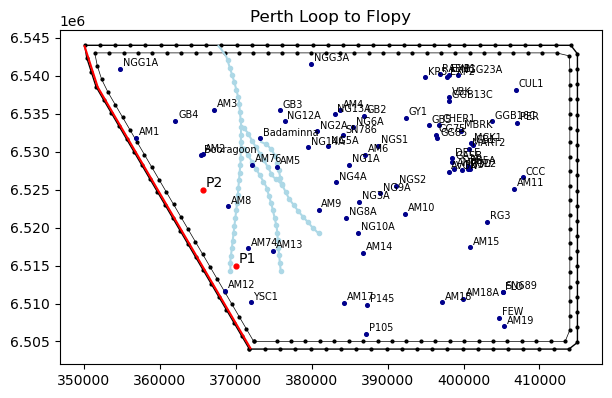

In [51]:
from loopflopy.spatial import Spatial
spatial = Spatial(epsg = 28350)

x0, x1, y0, y1 = 348000, 415000, 6504000, 6544000
from loopflopy.spatial_routines import create_bbox
create_bbox(spatial, x0, x1, y0, y1)


import process_spatial
process_spatial.model_boundary(spatial)
process_spatial.obs_bores(spatial)
process_spatial.pump_bores(spatial)
process_spatial.head_boundary(spatial)
process_spatial.faults(spatial)
process_spatial.plot_spatial(spatial)

In [52]:
m = spatial.obsbore_gdf.explore(location=[-31.4, 115.8], zoom_start=11, popup = 'ID')
#m = folium.Map(location=[52.0, 4.0], zoom_start=6) 
spatial.model_boundary_gdf.explore(m=m, fill = False)
spatial.faults_gdf.explore(m=m, color = 'red')

### 3. Meshing

In [53]:
from loopflopy.mesh import Mesh
special_cells = {'chd': ['west'], 
                 'wel': ['pumpbores'], 
                 'obs': ['obsbores'], }
mesh = Mesh(plangrid = 'tri', special_cells = special_cells) # special cells to identify as arguements 

In [54]:
mesh.modelmaxtri = 3000000
mesh.boundmaxtri = 999999999
mesh.angle = 32   # minimum triangle angles
mesh.radius1 = 200 # radius of inner circle around pumping bores
mesh.radius2 = 600 # radius of outer circle around pumping bores
mesh.boremaxtri = 99999999

mesh.create_bore_refinement(spatial)

node_list = ['faults_nodes', 'bore_refinement_nodes']
polygon_list = ['model_boundary_poly', 'inner_boundary_poly']

mesh.prepare_nodes_and_polygons(spatial, node_list, polygon_list)
mesh.create_mesh(project, spatial)

print('number of cells in plan = ', mesh.ncpl)

number of cells in plan =  1946


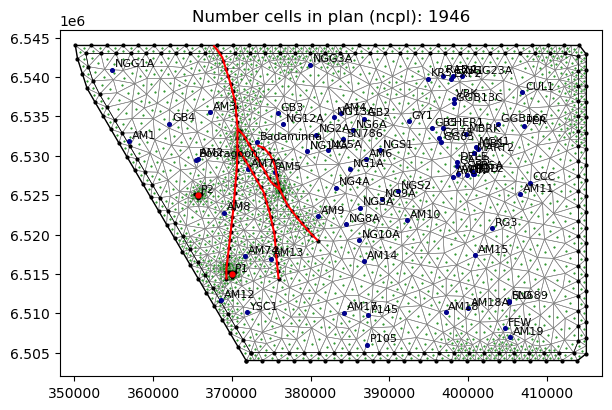

In [55]:
xlim = [spatial.x0 - 2000, spatial.x1 + 2000]
ylim = [spatial.y0 - 2000, spatial.y1 + 2000]

#xlim = [368000, 372000]
#ylim = [6512500, 6517500]

features = ['wel', 'obs', 'fault']
mesh.plot_cell2d(spatial, features, xlim, ylim)

### 5. Find Cell IDs of spatial features

Group =  chd ['west']
Group =  wel ['pumpbores']
Group =  obs ['obsbores']


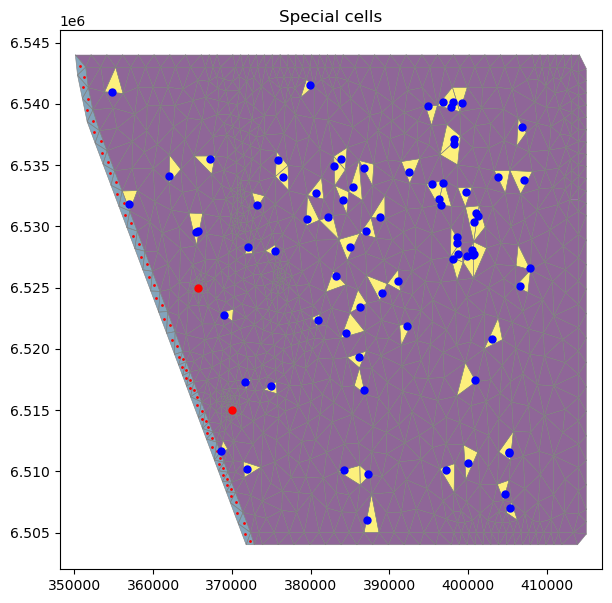

In [56]:
mesh.locate_special_cells(spatial)
mesh.plot_feature_cells(spatial, xlim, ylim)

### 4. Structural Model

In [57]:
spatial.z0, spatial.z1 = -2000, 200
# ------------------------------------------------------
geodata_fname = '../data/data_dwer/geology.xls'
data_sheetname = 'bore_info'
strat_sheetname = 'strat_info'

from loopflopy.structuralmodel import StructuralModel
structuralmodel = StructuralModel(spatial, geodata_fname, data_sheetname, strat_sheetname)

import process_structuralmodel 
process_structuralmodel.prepare_strat_column(structuralmodel)
extent = [343000,6483000,-3000,408000,6564000,200]
process_structuralmodel.prepare_geodata(structuralmodel, Lleyland = True, Brett = True,extent=extent)


here NGG21A  13
here RG2 13
here KR5 13
here AM1 13
here GB5 13
here AM7 13
here AM15 13
here AM18A 13
here AM22 13
here AM26 13
here AM25 13
here AM29 13


In [58]:
structuralmodel.strat

,sequence,unit,R,G,B,val,lithid,Thickness
0,Ground,Ground,255,255,255,0,-1,-
1,Quaternary,TQ,255,255,0,-44,0,44
2,Tertiary,Tk,255,81,42,-161,1,117
3,Lancelin,Kcp,196,214,155,-186,2,25
4,Lancelin,Kcg,170,217,153,-230,3,44
5,Lancelin,Kcm,171,199,182,-253,4,23
6,Osbourne,Kcom,168,164,0,-313,5,60
7,Osbourne,Kcok,255,204,153,-364,6,51
8,Osbourne,Kcoh,255,204,204,-386,7,22
9,Leederville,Kwlp,204,255,51,-440,8,54


In [59]:
structuralmodel.data

,ID,X,Y,Z,val,lithcode,feature_name,gx,gy,gz,for_Kerry
0,NGG20A,402004.51,6563226.68,177.37,0.0,Ground,Ground,0.0,0.0,1.0,raw_data
1,NGG20A,402004.51,6563226.68,177.37,-44.0,1,Tertiary,0.0,0.0,1.0,raw_data
2,NGG20A,402004.51,6563226.68,177.37,0.0,base_tert,Tert_U,0.0,0.0,1.0,raw_data
3,NGG20A,402004.51,6563226.68,177.37,-253.0,4,Lancelin,NaN,NaN,NaN,raw_data
4,NGG20A,402004.51,6563226.68,177.37,0.0,base_lanc,Lanc_U,0.0,0.0,1.0,raw_data
...,...,...,...,...,...,...,...,...,...,...,...
93,PET,389852.00,6550736.00,-3330.09,-4558.0,Jd,Yarragadee,NaN,NaN,NaN,WAPIMS
94,PET,395158.00,6560719.00,-3180.0,-4558.0,Jd,Yarragadee,NaN,NaN,NaN,WAPIMS
95,PET,388129.00,6557111.00,-3224.0,-4558.0,Jd,Yarragadee,NaN,NaN,NaN,WAPIMS
96,PET,388631.00,6552764.00,-3037.0,-4558.0,Jd,Yarragadee,NaN,NaN,NaN,WAPIMS


In [60]:
process_structuralmodel.create_structuralmodel(structuralmodel)

C:\Users\00098687\Anaconda3\envs\LOOP\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


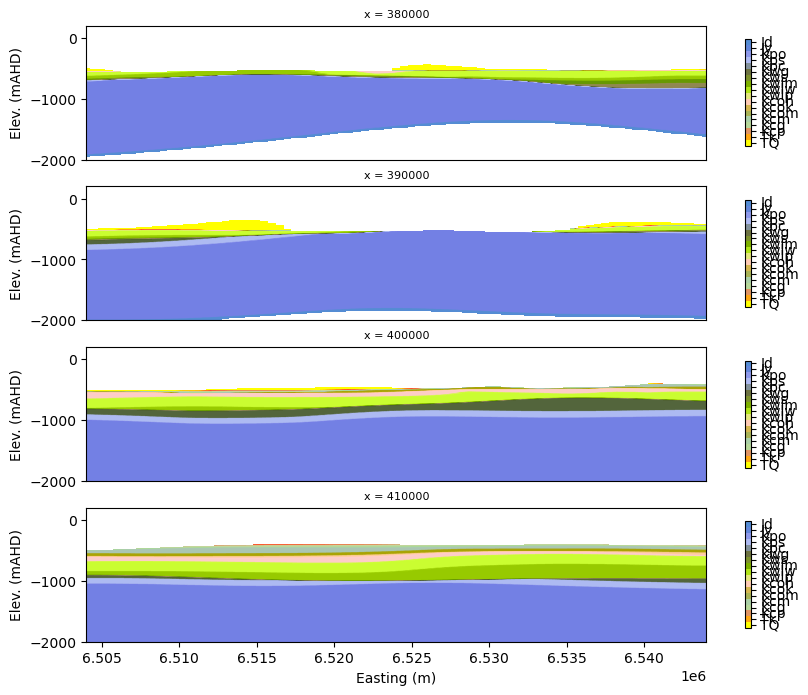

C:\Users\00098687\Anaconda3\envs\LOOP\Lib\site-packages\loopflopy\structuralmodel.py:87: UserWarning: Adding colorbar to a different Figure <Figure size 1000x800 with 9 Axes> than <Figure size 1000x800 with 1 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(csa,
C:\Users\00098687\Anaconda3\envs\LOOP\Lib\site-packages\loopflopy\structuralmodel.py:87: UserWarning: Adding colorbar to a different Figure <Figure size 1000x800 with 10 Axes> than <Figure size 1000x800 with 2 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(csa,
C:\Users\00098687\Anaconda3\envs\LOOP\Lib\site-packages\loopflopy\structuralmodel.py:87: UserWarning: Adding colorbar to a different Figure <Figure size 1000x800 with 11 Axes> than <Figure size 1000x800 with 3 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(csa,
C:\Users\00098687\Anaconda3\envs\LOOP\Lib\site-packages\loopflopy\structuralmodel.py:87: UserWarning: Adding colorbar to a different Figure <Figure size 1000x800 with 12 Axe

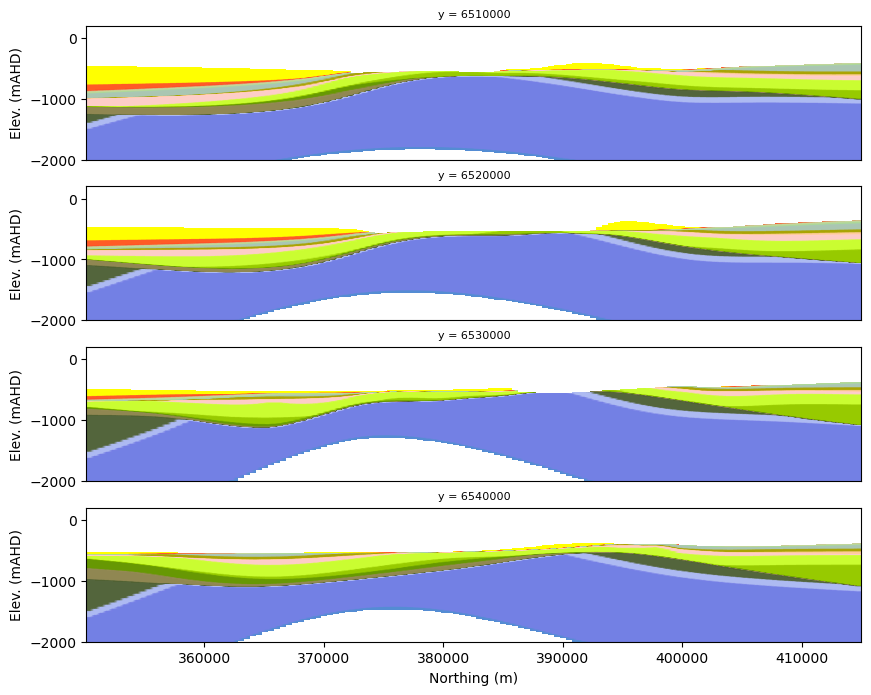

In [61]:
transect_x = [380000, 390000, 400000, 410000]
transect_y = [6510000, 6520000, 6530000, 6540000]
structuralmodel.make_cmap()
structuralmodel.plot_transects(transect_x, transect_y)

In [42]:
#structuralmodel.strat 
structuralmodel.strat_col 
#structuralmodel.strat_names 
#structuralmodel.cmap
#structuralmodel.norm 

{'Warnbro': {'Kws': {'min': -783,
   'max': inf,
   'id': 11,
   'color': [0.58, 0.54, 0.33],
   'colour': array([0.12156863, 0.46666667, 0.70588235, 1.        ])},
  'Kwg': {'min': -inf,
   'max': -783,
   'id': 12,
   'color': [0.31, 0.38, 0.2],
   'colour': array([0.12156863, 0.46666667, 0.70588235, 1.        ])}},
 'Lancelin': {'Kcp': {'min': -186,
   'max': inf,
   'id': 2,
   'color': [0.77, 0.84, 0.61],
   'colour': array([0.12156863, 0.46666667, 0.70588235, 1.        ])},
  'Kcg': {'min': -230,
   'max': -186,
   'id': 3,
   'color': [0.67, 0.85, 0.6],
   'colour': array([0.12156863, 0.46666667, 0.70588235, 1.        ])},
  'Kcm': {'min': -inf,
   'max': -230,
   'id': 4,
   'color': [0.67, 0.78, 0.71],
   'colour': array([0.12156863, 0.46666667, 0.70588235, 1.        ])}},
 'Tertiary': {'Tk': {'min': -inf,
   'max': inf,
   'id': 1,
   'color': [1.0, 0.32, 0.16],
   'colour': array([0.12156863, 0.46666667, 0.70588235, 1.        ])}},
 'Osbourne': {'Kcom': {'min': -313,
   'max

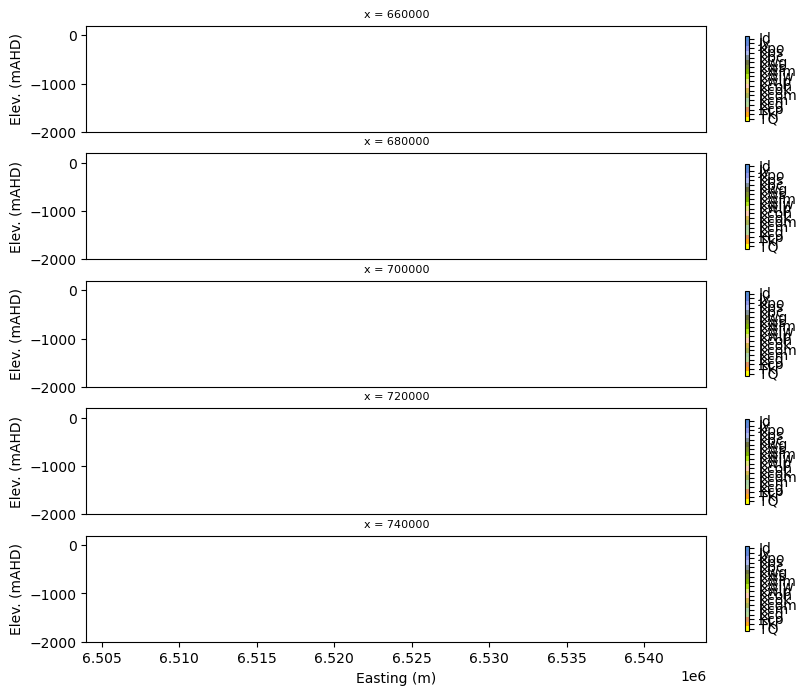

C:\Users\00098687\Anaconda3\envs\LOOP\Lib\site-packages\loopflopy\structuralmodel.py:87: UserWarning: Adding colorbar to a different Figure <Figure size 1000x800 with 11 Axes> than <Figure size 1000x800 with 1 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(csa,
C:\Users\00098687\Anaconda3\envs\LOOP\Lib\site-packages\loopflopy\structuralmodel.py:87: UserWarning: Adding colorbar to a different Figure <Figure size 1000x800 with 12 Axes> than <Figure size 1000x800 with 2 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(csa,
C:\Users\00098687\Anaconda3\envs\LOOP\Lib\site-packages\loopflopy\structuralmodel.py:87: UserWarning: Adding colorbar to a different Figure <Figure size 1000x800 with 13 Axes> than <Figure size 1000x800 with 3 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(csa,
C:\Users\00098687\Anaconda3\envs\LOOP\Lib\site-packages\loopflopy\structuralmodel.py:87: UserWarning: Adding colorbar to a different Figure <Figure size 1000x800 with 14 Ax

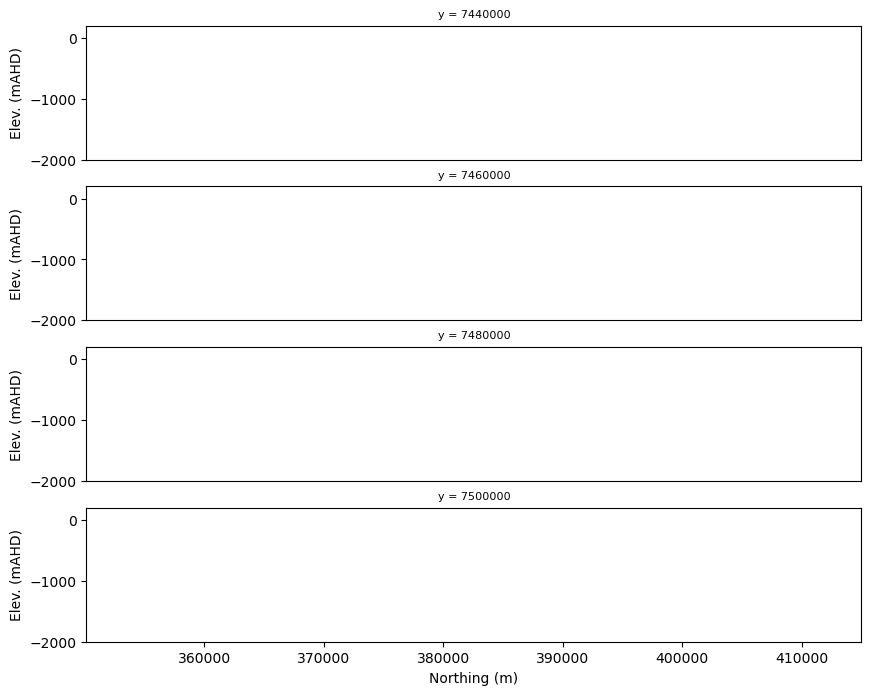

In [43]:
transect_x = [660000, 680000, 700000, 720000, 740000]
transect_y = [7440000, 7460000, 7480000, 7500000]
structuralmodel.make_cmap()
structuralmodel.plot_transects(transect_x, transect_y)

### 5. Extract surfaces

In [44]:
print(structuralmodel.model.bounding_box.nsteps)
structuralmodel.model.bounding_box.nelements = 1e6
print(structuralmodel.model.bounding_box.nsteps)

# Extract surfaces
surfaces = structuralmodel.model.get_stratigraphic_surfaces()

from LoopStructural.interpolators.supports import P1Unstructured2d

lith_id = 1
loopmesh = P1Unstructured2d(surfaces[lith_id].triangles, surfaces[lith_id].vertices[:, 0:2], surfaces[lith_id].triangles[:, 0:3]) # Ground is surfaces [0] (ELEMENTS, VERTICES, NEIGHBOURS)
#pts = mesh.xcyc  #structured2d.barycentre # replace with my xcyc
#z = loopmesh.evaluate_value(pts, surfaces[lith_id].vertices[:, 2])

## we expect the values to be close to zero depending on the resultion of the interpolation
#geomodel["Ground"].evaluate_value(np.hstack([pts, z[:, np.newaxis]]))
#surface = structuralmodel.model['Ground'].surfaces([0])[0]


[50 50 25]
[363 224  13]


In [45]:
loopmesh.minimum, loopmesh.maximum

(array([nan, nan]), array([nan, nan]))

In [46]:
loopmesh.elements

array([[   2,    1,    0],
       [   3,    1,    2],
       [   3,    4,    1],
       ...,
       [6393, 6323, 6322],
       [6393, 6324, 6323],
       [6395, 6324, 6393]], dtype=int32)

In [47]:
#dir(loopmesh)

In [48]:
print(mesh.xcyc.shape)
print(mesh.xcyc[0])
print(np.unique(z))
print(loopmesh.minimum, loopmesh.maximum)

(1946, 2)
[ 366170.12299394 6514956.27333741]


NameError: name 'z' is not defined

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(1, 1, 1, aspect="equal")
pmv = flopy.plot.PlotMapView(modelgrid=mesh.vgrid)
p = pmv.plot_array(z, alpha = 0.6)
mesh.tri.plot(ax=ax, edgecolor='black', lw = 0.1)
# Add on polygons to plot
x, y = spatial.streams_poly.exterior.xy
ax.plot(x, y, '-o', ms = 2, lw = 0.5, color='blue') 

spatial.obsbore_gdf.plot(ax=ax, markersize = 7, color = 'darkblue', zorder=2)
spatial.pumpbore_gdf.plot(ax=ax, markersize = 12, color = 'red', zorder=2)

for cell in mesh.stream_cells:
    ax.plot(mesh.cell2d[cell][1], mesh.cell2d[cell][2], "o", color = 'blue', ms = 1)
for cell in mesh.obs_cells:
    ax.plot(mesh.cell2d[cell][1], mesh.cell2d[cell][2], "o", color = 'black', ms = 1)
for cell in mesh.wel_cells:
    ax.plot(mesh.cell2d[cell][1], mesh.cell2d[cell][2], "o", color = 'red', ms = 2)


### 5. Geomodel

In [ ]:
# voxel: nlay, z0, z1
# con:   nls, res
# con2:  nls, res, max_thick

scenario = 'homogeneous'
vertgrid = 'con'    # 'vox', 'con' or 'con2'
z0, z1 = 200, 3000

from make_geomodel import Geomodel
geomodel = Geomodel(scenario, vertgrid, z0, z1, nls = 2, res = 2)#, max_thick = 100. * np.ones((7)))

geomodel.create_lith_dis_arrays(mesh, structuralmodel)
geomodel.vgrid = flopy.discretization.VertexGrid(vertices=mesh.vertices, cell2d=mesh.cell2d, ncpl = mesh.ncpl, top = geomodel.top_geo, botm = geomodel.botm)
geomodel.get_surface_lith()

In [ ]:
X0, X1, Y0, Y1 = spatial.x0, spatial.x1, spatial.y0, spatial.y1 #7460000, 7460000
geomodel.make_cmap(structuralmodel)
geomodel.geomodel_plan_lith(spatial, mesh, structuralmodel,  X0, Y0, X1, Y1)
geomodel.geomodel_transect_lith(structuralmodel, X0, Y0, X1, Y1) 

In [ ]:
# FILL CELL PROPERTIES

geomodel.hk_perlay = [1., 1., 0.5, 0.1, 0.2, 5., 10.]
geomodel.vk_perlay = [0.1, 0.1, 0.05, 0.01, 0.02, 0.5, 1]
geomodel.ss_perlay = [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001]
geomodel.sy_perlay = [0.1 for i in range(7)]

geomodel.fill_cell_properties(mesh)


### 6. Prepare Data for Flowmodel

In [ ]:
from process_data import Data
data = Data()

data.process_ic(geomodel, mesh)
data.process_rch(mesh)
data.process_chd(geomodel, mesh)

wel_q = [-0, -0]
wel_qlay= [5, 2]
data.process_wel(geomodel, mesh, spatial, well_q, wel_qlay)


### 7. Prepare Observations

In [ ]:
from process_observations import Observations
observations = Observations()
observations.process_obs(spatial, geomodel, mesh)

### 8. Create and run steady-state flow model

In [ ]:
from make_flowmodel import Flowmodel
project.mfexe_name = '../exe/mf6.exe'

In [ ]:
scenario = 'steadymodel'

fmss = Flowmodel(scenario, project, data, observations, mesh, geomodel)
fmss.lith = geomodel.lith
fmss.logk11 = geomodel.logk11
fmss.logk33 = geomodel.logk33
len(fmss.lith.flatten())

In [ ]:
# Write and run flow model files
sim = fmss.write_flowmodel(chd = True, wel = True, obs = True, rch = True)
fmss.run_flowmodel(sim)

In [ ]:
obj = fmss
methods = [func for func in dir(obj) if callable(getattr(obj, func)) and not func.startswith("__")]
print("Methods in the class:  ",methods)
attributes = [attr for attr in dir(obj) if not callable(getattr(obj, attr)) and not attr.startswith("__")]
print("\nAttributes in the class:  ", attributes)

#for attribute, value in flowmodel.data.__dict__.items(): print(attribute)

In [ ]:
import plotting_routines

#vmin, vmax = min(flowmodel.head.flatten()), max(flowmodel.head.flatten())
extent = [spatial.x0, spatial.x1, spatial.y0, spatial.y1]
X0, X1, Y0, Y1 = spatial.x0, spatial.x1, 7440000, 7440000
plotting_routines.plot_watertable(spatial, mesh, geomodel, fmss, watertable, extent = extent)#, vmin=vmin, vmax=vmax)
plotting_routines.plot_transect(spatial, fmss, array, X0, X1, Y0, Y1)#, vmin, vmax)

### 9. Create and run transient flow model

In [ ]:
scenario = 'transientmodel'
well_q = [-2000, -2000]
data.process_wel(geomodel, mesh, spatial, well_q, wel_qlay)
data.strt = fmss.head
flowmodel = Flowmodel(scenario, project, data, observations, mesh, geomodel)

perlen = 2 * 365 # length of period (days)
nts = 12         # number of time steps for this period
flowmodel.perioddata = [(perlen, nts, 1.1)] # perlen, nts, tsmult

In [ ]:
sim = flowmodel.write_flowmodel(transient = True, chd = True, wel = True, obs = True, rch = True)

In [ ]:
flowmodel.run_flowmodel(sim, transient = True)

In [ ]:
watertable = flowmodel.get_watertable(geomodel, flowmodel.head)

### 10. Visualise Results

In [ ]:
import plotting_routines

vmin, vmax = 495, 505 #min(flowmodel.head.flatten()), max(flowmodel.head.flatten())
extent = [spatial.x0, spatial.x1, spatial.y0, spatial.y1]
X0, X1, Y0, Y1 = spatial.x0, spatial.x1, 7440000, 7440000
plotting_routines.plot_watertable(spatial, mesh, geomodel, flowmodel, watertable, extent = extent)#, vmin=vmin, vmax=vmax)
plotting_routines.plot_transect(spatial, flowmodel, array, X0, X1, Y0, Y1)#, vmin, vmax)

# PLOT BY LAYER
#from plotting_routines import plot_plan
#array = 'head'
#layer = 0
#plot_plan(spatial, mesh, flowmodel, array, layer, extent = extent, vmin=vmin, vmax=vmax, vectors = True)

### 11. Forecasting

In [ ]:

class Forecast:
    def __init__(self, name):
        self.name = name

forecast = Forecast('forecast_scenario_1')
forecast.qwell = [-200000, -200000] #m3/d 


In [ ]:
scrap code

# FOR TRANSIENT
rch_list = []
for index, row in df.iterrows(): 
    for i in range(4,16): # Jan-Dec
        rch_list.append(row.iloc[i]/1000) # mm to m

nper = len(rch_list)
ncpl = len(cell2d)

# FOR HFB IF WE USE

# import disv2disu # MODFLOW Tools
# Disv2Disu = disv2disu.Disv2Disu    
# nlay = 1
# botm = np.zeros_like(top).reshape(1, len(cell2d))
# idomain = np.ones_like(top).reshape(1, len(cell2d))
# dv2d = Disv2Disu(vertices, cell2d, top, botm, staggered=False, disv_idomain = idomain)
# dv2d._neighbors
# #dv2d._edge_set
# 
# dyke_K, dyke_width = 0.0001, 2  
# hydchr = dyke_K / dyke_width  
# 
# # Set up Horizontal Flow Barrier (HFB)
# for n in range(gdf.shape[0]): # For each dyke...
#     # Vertical
#     for lay in range(nlay):
#         for cell ibd[cell]
#         if zc[lay, icpl] < dyke_top[n]: 
#             hfb.append(([lay, cellid_1], [k, cellid_2], hydchr))

#### FAULT
#P.fault_buffer = 800

# Import fault shape file
#bada_shp = gpd.read_file('../data/shp/badaminna_trace.shp')
#bada_shp.to_crs(epsg=28350, inplace=True)
#bada_shp = gpd.clip(bada_shp, model_boundary)

#from meshing_routines import prepare_fault_nodes_voronoi
#fault_refinement_nodes = prepare_fault_nodes_voronoi(P, '../data/shp/badaminna_trace.shp', model_boundary, inner_boundary)

In [ ]:
import itertools

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation


def data_gen():
    for cnt in itertools.count():
        t = cnt / 10
        yield t, np.sin(2*np.pi*t) * np.exp(-t/10.)


def init():
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlim(0, 1)
    del xdata[:]
    del ydata[:]
    line.set_data(xdata, ydata)
    return line,

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.grid()
xdata, ydata = [], []


def run(data):
    # update the data
    t, y = data
    xdata.append(t)
    ydata.append(y)
    xmin, xmax = ax.get_xlim()

    if t >= xmax:
        ax.set_xlim(xmin, 2*xmax)
        ax.figure.canvas.draw()
    line.set_data(xdata, ydata)

    return line,

# Only save last 100 frames, but run forever
ani = animation.FuncAnimation(fig, run, data_gen, interval=100, init_func=init,
                              save_count=100)
plt.show()

In [ ]:
# METHOD BARDOT 2024
from meshing_routines import resample_linestring
import itertools
from datetime import datetime

t0 = datetime.now()

def voronoi_nodes_gdf(gdf, refinement_boundary_poly, buffer):

    dyke = []
    hfb_1, hfb_2 = [], []
    nodes = []
    
    for n in range(gdf.shape[0]): 
        
        # Dykes notes (on the dyke linestring)
        linestring = dykes_gdf.geometry[n]
        r = 2*buffer/3 # distance between points
        ls_resample = resample_linestring(linestring, r) # resample orginal dyke line
        dyke.append(ls_resample)
        
        # Refinement nodes
        offsets = [-1.5*r, -0.5*r, 0.5*r, 1.5*r]
        fault_offset_lines = []
        for i, offset in enumerate(offsets):
            ls = linestring.parallel_offset(offset) # linestring.parallel_offset
            ls_resample = resample_linestring(ls, r)
            
            p = []
            for point in ls_resample:
                x,y = point.x, point.y
                p.append((x,y))
                #if refinement_boundary_poly.contains(point):
                #    x,y = point.x, point.y
                #    p.append((x,y))
            
            if len(p) != 1: # just incase there is a 1 point linestring
                offset_ls = LineString(p)
                coords = list(offset_ls.coords)
                fault_offset_lines.append(coords) 
                if i == 1: # SIDE 1
                    hfb_1.append(coords)
                if i == 2: # SIDE 2
                    hfb_2.append(coords)
                
        nodes.append([tup for line in fault_offset_lines for tup in line]) 
    refinement_nodes = list(itertools.chain.from_iterable(nodes))

    return(refinement_nodes, hfb_1, hfb_2)

# Import dykes shape file
dykes_gdf = gpd.read_file('../data_shp/dykes_m.shp')
dykes_gdf.to_crs(epsg=28350, inplace=True)
dykes_gdf = gpd.clip(dykes_gdf, inner_boundary_poly).reset_index(drop=True)
#dykes_gdf.plot()

dyke_nodes, hfb_1, hfb_2 = voronoi_nodes_gdf(dykes_gdf, refinement_boundary_poly, buffer)

t1 = datetime.now()
print(t1 - t0) 

In [ ]:

from sklearn.cluster import DBSCAN
from alphashape import alphashape

def create_surfacegeo_polys(geomodel, lith):
    points = []
    a = np.array(mesh.cell2d)
    b = a[geomodel.surf_lith==lith]
    verts = np.unique(b[:,4:7].flatten())
    verts = [int(x) for x in verts]
    vert_coords = []
    for v in verts:
        vert_coords.append(mesh.vertices[v][1:3])
    xlist, ylist = list(zip(*vert_coords))
    gdf = gpd.GeoDataFrame(pd.DataFrame({'x': xlist, 'y': ylist}), 
                           geometry = gpd.points_from_xy(x = xlist, y = ylist))
    # Extract coordinates for clustering
    coords = gdf.geometry.apply(lambda geom: (geom.x, geom.y)).tolist()
    
   # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=5000, min_samples=3)  # eps: max distance for clustering
    gdf['cluster'] = dbscan.fit_predict(coords)
    
    # Create concave hulls for each cluster
    hulls = []
    for cluster_id in gdf['cluster'].unique():
        
        if cluster_id != -1:  # Exclude noise points
            cluster_points = gdf[gdf['cluster'] == cluster_id]
            print('\ncluster id = ', cluster_id, ', number of points = ', len(cluster_points))
            points_list = cluster_points.geometry.apply(lambda p: (p.x, p.y)).tolist()
            
            # CONCAVE
            mp = MultiPoint(points_list)
            gs = gpd.GeoSeries(mp)
            hull = gs.concave_hull(ratio = 0.2, allow_holes = False)
            hulls.append(hull)
    
    hull_gdf = gpd.GeoDataFrame(pd.concat(hulls, ignore_index=True), columns=['geometry'])
    return (gdf, hull_gdf)

def plot_geology_polygons(gdf, hull_gdf):
    # Plot results
    fig, ax = plt.subplots()
    gdf.plot(ax=ax, color='blue', markersize=3, label='Points')
    hull_gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1, label='Concave Hulls')
    plt.legend()
    plt.show()

for i in range(7):
    gdf, hull_gdf = create_surfacegeo_polys(geomodel, i)
    plot_geology_polygons(gdf, hull_gdf)

In [ ]:
print(structuralmodel.model.bounding_box.nsteps)
structuralmodel.model.bounding_box.nelements = 1e6
print(structuralmodel.model.bounding_box.nsteps)

# Extract surfaces
surfaces = structuralmodel.model.get_stratigraphic_surfaces()

# Interpolate onto a structured grid
from LoopStructural.interpolators.supports import P1Unstructured2d, StructuredGrid2D
loopmesh = P1Unstructured2d(surfaces[0].triangles, surfaces[0].vertices[:, 0:2], surfaces[0].triangles[:, 0:3]) # Ground is surfaces [0] (ELEMENTS, VERTICES, NEIGHBOURS)
# loopmesh
#dx, dy = 1000, 1000 # 1000m cells
#nx = int((structuralmodel.x1 - structuralmodel.x0)/dx)
#ny = int((structuralmodel.y1 - structuralmodel.y0)/dy)
#structured2d = StructuredGrid2D(origin=[structuralmodel.x0, structuralmodel.y0], nsteps=[nx, ny], step_vector= [dx, dy])
pts = mesh.xcyc  #structured2d.barycentre # replace with my xcyc
z = loopmesh.evaluate_value(pts, surfaces[0].vertices[:, 2])
np.unique(z)
## we expect the values to be close to zero depending on the resultion of the interpolation
#geomodel["Ground"].evaluate_value(np.hstack([pts, z[:, np.newaxis]]))

surface = structuralmodel.model['Ground'].surfaces([0])[0]
#surfaces = structuralmodel.model.get_stratigraphic_surfaces(units = ['Ground'])
p = Loop3DView(structuralmodel.model)
p.plot_model_surfaces()
for s in surfaces:
    p.add_mesh(s.vtk())
p.add_points(surface.vertices)
#p.add_mesh(surfaces[0].vtk)
p.show()

from LoopStructural.visualisation import Loop3DView
p = Loop3DView(structuralmodel.model)
p.plot_model_surfaces()

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1, aspect="equal")
pmv = flopy.plot.PlotMapView(modelgrid=geomodel.vgrid)
arr = pmv.plot_array(geomodel.idomain[0], alpha = 0.6) #(M.botm_geo[0], alpha = 0.6)
mesh.tri.plot(ax=ax, edgecolor='black', lw = 0.1)
cbar = fig.colorbar(arr, ax=ax, shrink = 0.5)  